In [1]:
from Database import Preprocess
from Model import Model
from Model import two_model
from Database import DQR    
import sweetviz as sv
import pandas as pd

/opt/anaconda3/envs/freeway/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# info

In [2]:
"""
check before run :
    get_data.py 
        1. __fetch_all_ETagPairLive
        2. __fetch_all_data 的 data_source 
    preprocess.py
        * 各種print 
    main.py
        1. segment_id_needed
        2. Preprocess 的 already_fetched
            * assets 要不要刪掉

other warning:
    * preprocess.py
        1. __get_car_frequency 的車子type mapping 是寫死的
        2. 暫時無法確定改成modin之後是不是執行正確的（只有少數資料的時候）
        3. 沒跑過modin有大量資料的時候能不能跑
    * modin 
        * interrupt時會有一堆warning，是正常的。
"""

'\ncheck before run :\n    get_data.py \n        1. __fetch_all_ETagPairLive\n        2. __fetch_all_data 的 data_source \n    preprocess.py\n        * 各種print \n    main.py\n        1. segment_id_needed\n        2. Preprocess 的 already_fetched\n            * assets 要不要刪掉\n\nother warning:\n    * preprocess.py\n        1. __get_car_frequency 的車子type mapping 是寫死的\n        2. 暫時無法確定改成modin之後是不是執行正確的（只有少數資料的時候）\n        3. 沒跑過modin有大量資料的時候能不能跑\n    * modin \n        * interrupt時會有一堆warning，是正常的。\n'

# Fetch and preprocess data 

In [3]:
segment_id_needed = [
    {"ID" : "01F0928N-01F0880N", "from" : "新竹(新竹、竹東)-竹北", "to" : "竹北-湖口"},
    {"ID" : "01F0956N-01F0928N", "from" : "新竹(科學工業園區)-新竹(新竹、竹東)", "to" : "新竹(新竹、竹東)-竹北"},
    {"ID" : "01F0979N-01F0956N", "from" : "新竹系統-新竹(科學工業園區)", "to" : "新竹(科學工業園區)-新竹(新竹、竹東)"},
    {"ID" : "01F1045N-01F0979N", "from" : "頭份-新竹系統", "to" : "新竹系統-新竹(科學工業園區)"},

    {"ID" : "01F0880S-01F0928S", "from" : "湖口-竹北", "to" : "竹北-新竹(新竹、竹東)"}, 
    {"ID" : "01F0928S-01F0950S", "from" : "竹北-新竹(新竹、竹東)", "to" : "新竹(新竹、竹東)-新竹(科學工業園區)"},
    {"ID" : "01F0950S-01F0980S", "from" : "新竹(新竹、竹東)-新竹(科學工業園區)", "to" : "新竹(科學工業園區)-新竹系統"},
    {"ID" : "01F0980S-01F1045S", "from" : "新竹(科學工業園區)-新竹系統", "to" : "新竹系統-頭份"},
]
car_code_needed = [31, 32, 41, 42, 5] # 31小客車 32小貨車 41大客車 42大貨車 5聯結車
already_fetched         = True
already_preprocessed    = True

preprocess_var = Preprocess(segment_id_needed, car_code_needed, already_fetched, already_preprocessed)
preprocessed_data = preprocess_var.get_preprocessed_data()
car_map = preprocess_var.get_car_map()
print(preprocessed_data.head())
print(car_map)

	Connected to the database
	All data already fetched, skip fetching data from internet.
	Car frequency already fetched, skip fetching from database.
	Preprocessed data already fetched, skip preprocessing.
   id         ETagPairID direction  highway  start_mileage  end_mileage  year  \
0   1  01F0928N-01F0880N         N        1           92.8         88.0  2023   
1   2  01F0928N-01F0880N         N        1           92.8         88.0  2023   
2   3  01F0928N-01F0880N         N        1           92.8         88.0  2023   
3   4  01F0928N-01F0880N         N        1           92.8         88.0  2023   
4   5  01F0928N-01F0880N         N        1           92.8         88.0  2023   

     car  speed         utc  ...  construction_第二車道  construction_第三車道  \
0  0.049   84.0  1672531200  ...                  0                  0   
1  0.083   88.0  1672531200  ...                  0                  0   
2  0.869   96.0  1672531200  ...                  0                  0   
3  0.049   8

# Select data needed

In [4]:
all_columns = [ 'UTC',
        'ETagPairID', 'direction', 'highway', 'start_mileage', 'end_mileage', 'car', 'speed', 
        'year', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'five_minute_sin', 'five_minute_cos', 
        'is_weekend', 'is_holiday', 'holiday_sin', 'holiday_cos',
        'has_accident', 'recovery_time', 'accident_level', 'traffic_accident_內路肩', 'traffic_accident_內車道', 'traffic_accident_中內車道', 'traffic_accident_中車道', 'traffic_accident_中外車道', 'traffic_accident_外車道', 'traffic_accident_外路肩', 'traffic_accident_匝道',
        'has_construction', 'construction_time', 'construction_第一車道', 'construction_第二車道', 'construction_第三車道', 'construction_第四車道', 'construction_第五車道', 'construction_第六車道', 'construction_第七車道', 'construction_第八車道', 'construction_外側路肩', 'construction_內邊坡', 'construction_外邊坡'
    ]
column_needed = [
    'car', 
    'speed',
    'month_sin', 'month_cos', 'day_sin', 'day_cos',
    'five_minute_sin', 'five_minute_cos', 
    'is_weekend', 
    'is_holiday', 
    'holiday_sin', 'holiday_cos',
    'has_accident', 
    'recovery_time', 
    'accident_level', 
    'traffic_accident_內路肩', 'traffic_accident_內車道', 'traffic_accident_中內車道', 'traffic_accident_中車道', 'traffic_accident_中外車道', 'traffic_accident_外車道', 'traffic_accident_外路肩', 'traffic_accident_匝道', 
    'has_construction', 
    'construction_time', 
    'construction_第一車道', 'construction_第二車道', 'construction_第三車道', 'construction_第四車道', 'construction_第五車道', 'construction_第六車道', 'construction_第七車道', 'construction_第八車道', 'construction_外側路肩', 'construction_內邊坡', 'construction_外邊坡'
    ]
first_data = preprocessed_data.query(f"ETagPairID == '01F0928N-01F0880N'")
# first_data = preprocessed_data.query(f"speed > 0 and speed < 150")
first_data = first_data.query(f"speed > 0 and speed < 150")
first_data = first_data.query(f"car == 0.869")
# third_data = second_data.query(f"construction_time > 0")

# Evaluate data quality

Data Quality Report
Total columns: 36
Total rows: 74125
car                      float64
speed                    float64
month_sin                float64
month_cos                float64
day_sin                  float64
day_cos                  float64
five_minute_sin          float64
five_minute_cos          float64
is_weekend                 int64
is_holiday                 int64
holiday_sin              float64
holiday_cos              float64
has_accident               int64
recovery_time              int64
accident_level             int64
traffic_accident_內路肩       int64
traffic_accident_內車道       int64
traffic_accident_中內車道      int64
traffic_accident_中車道       int64
traffic_accident_中外車道      int64
traffic_accident_外車道       int64
traffic_accident_外路肩       int64
traffic_accident_匝道        int64
has_construction           int64
construction_time          int64
construction_第一車道          int64
construction_第二車道          int64
construction_第三車道          int64
construction_第四車道   

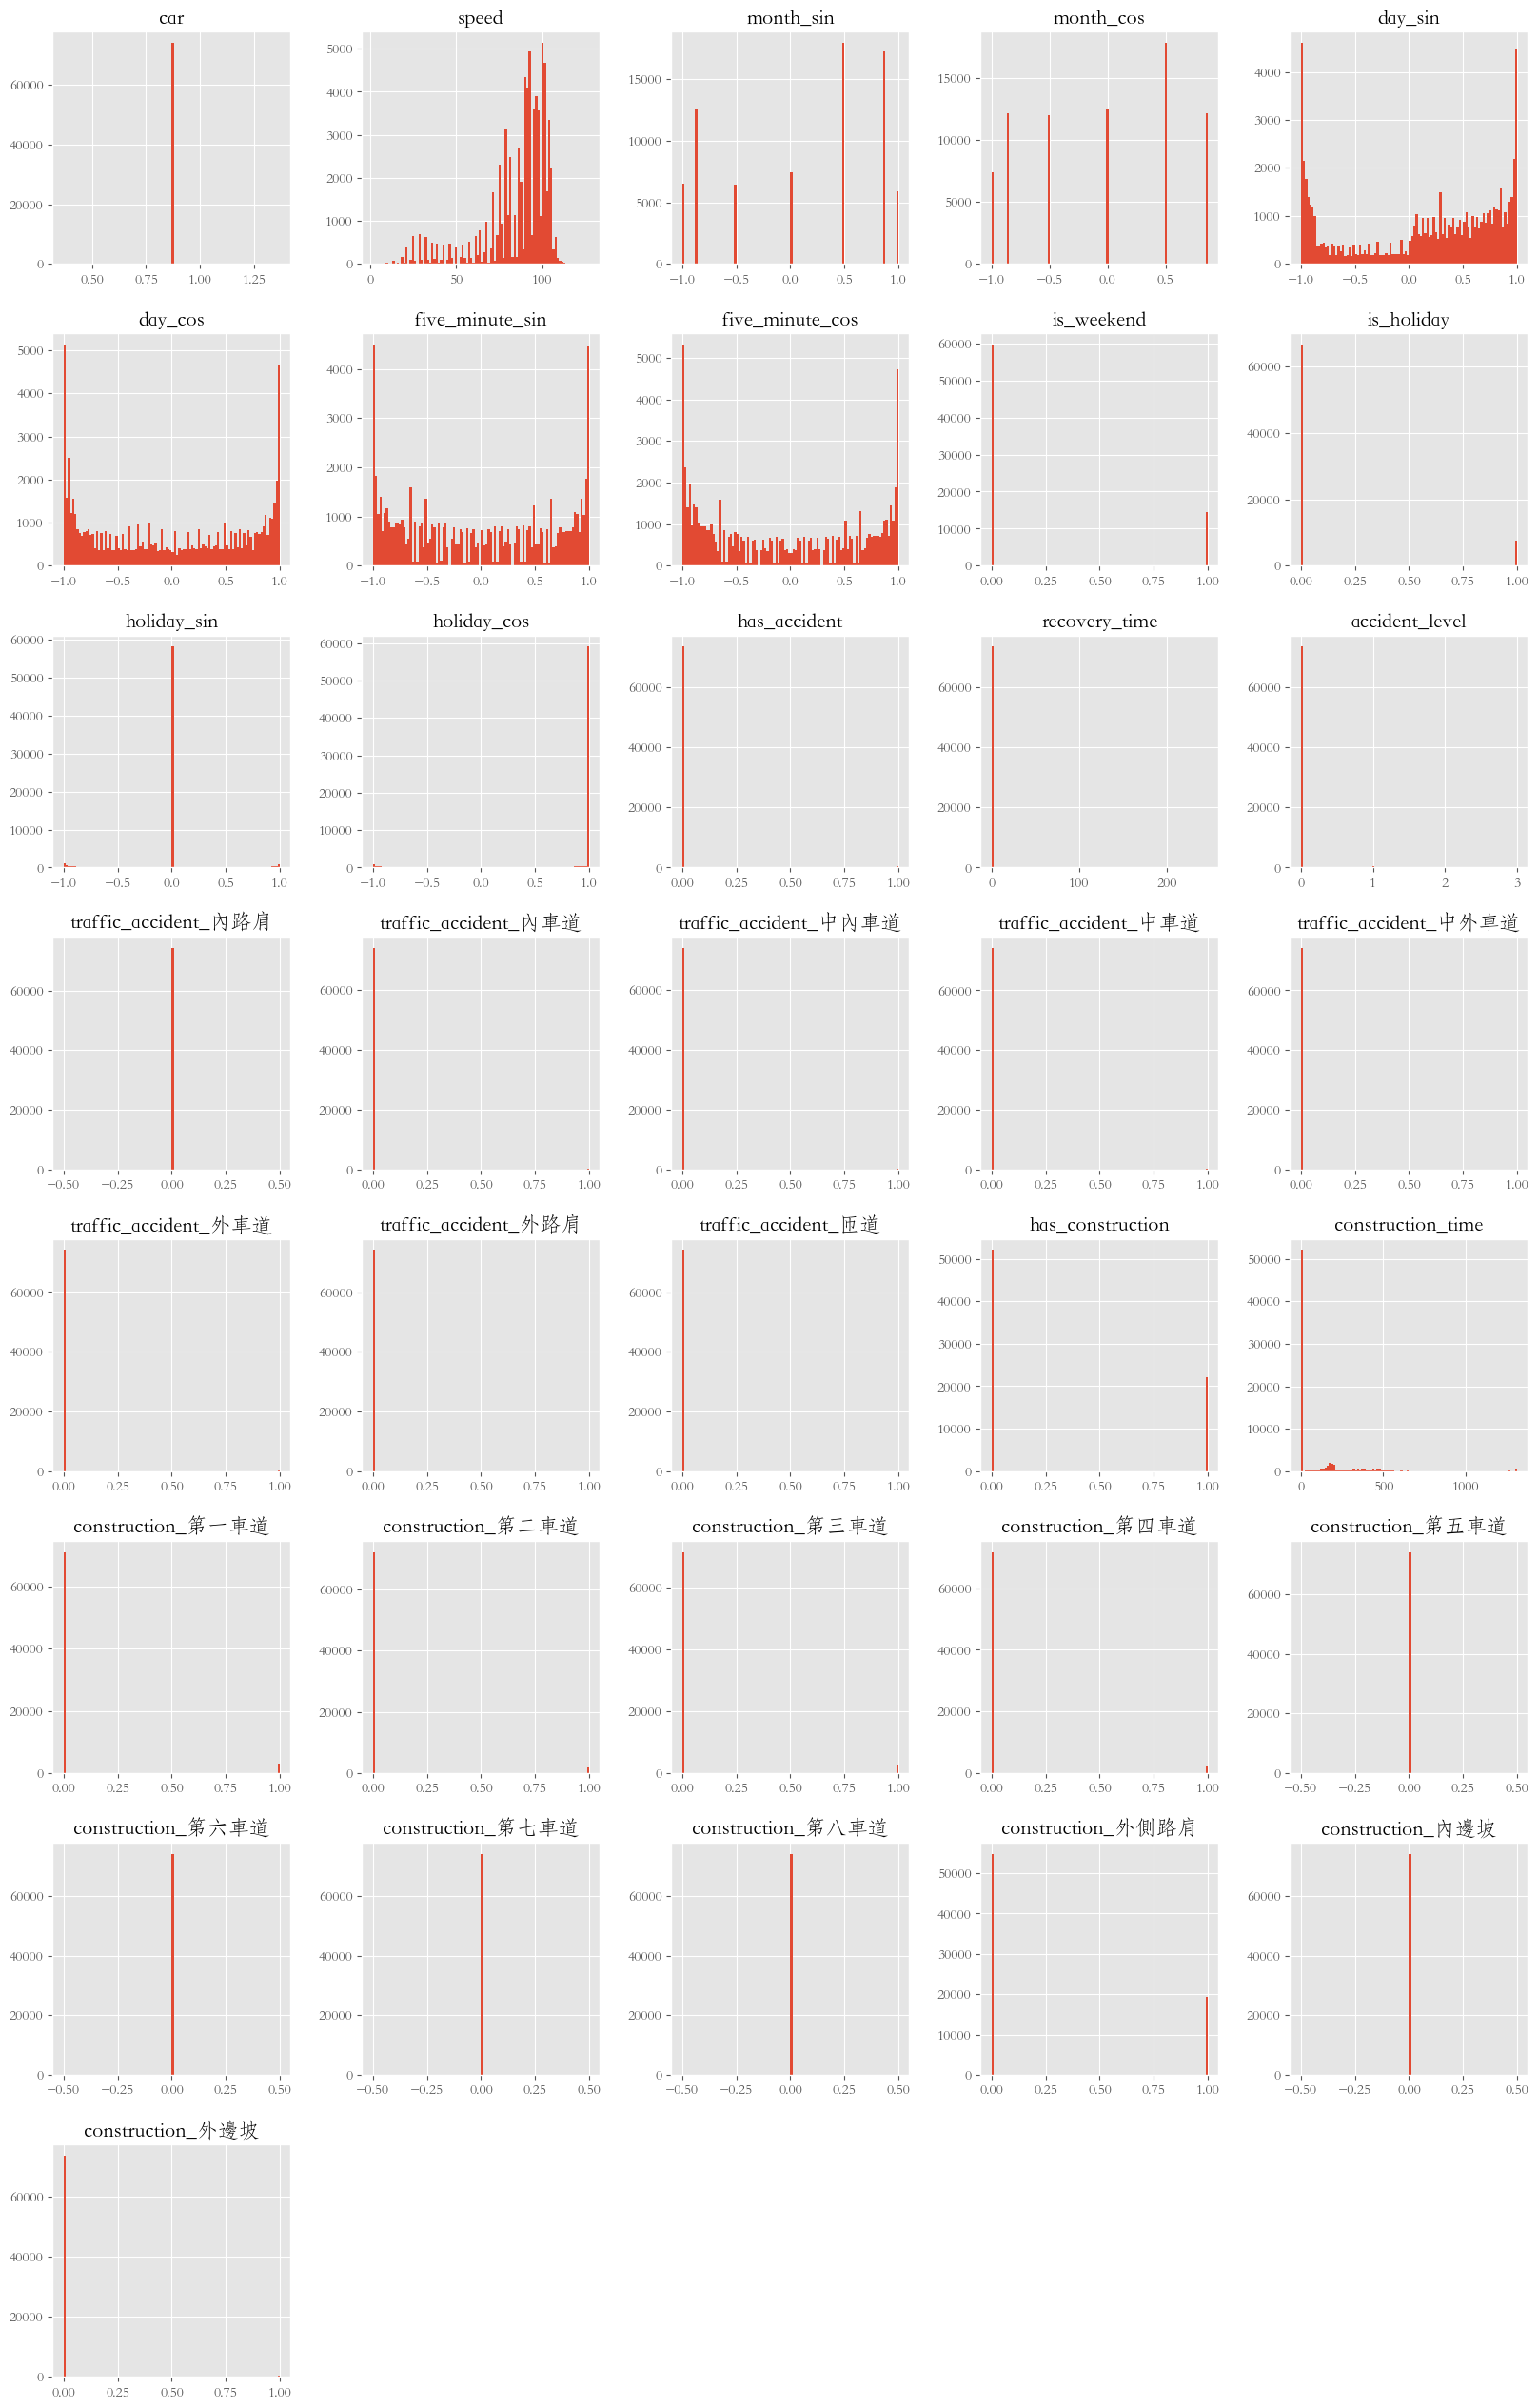

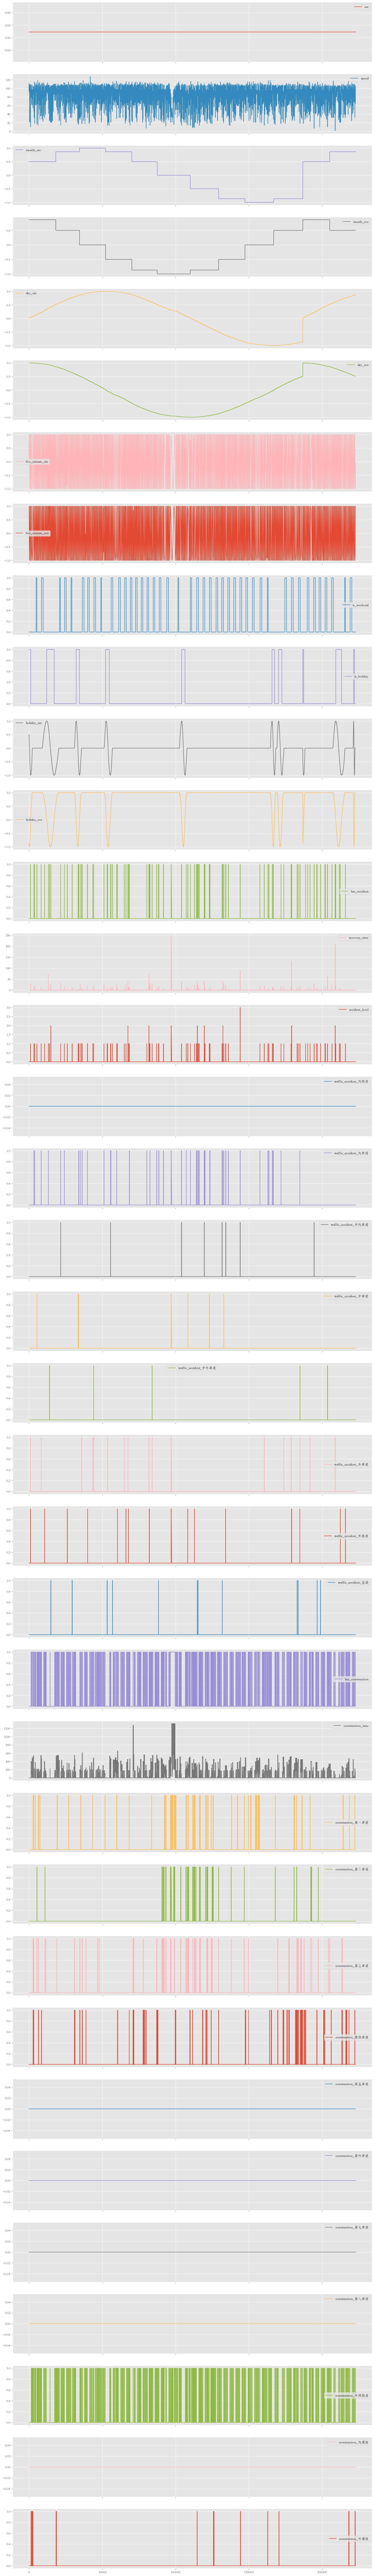

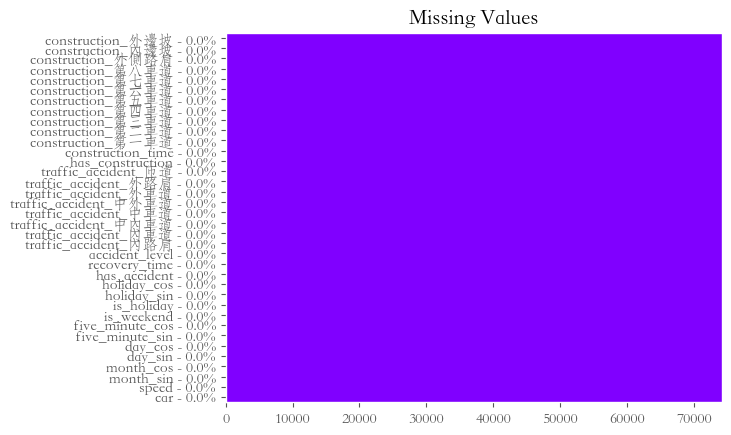

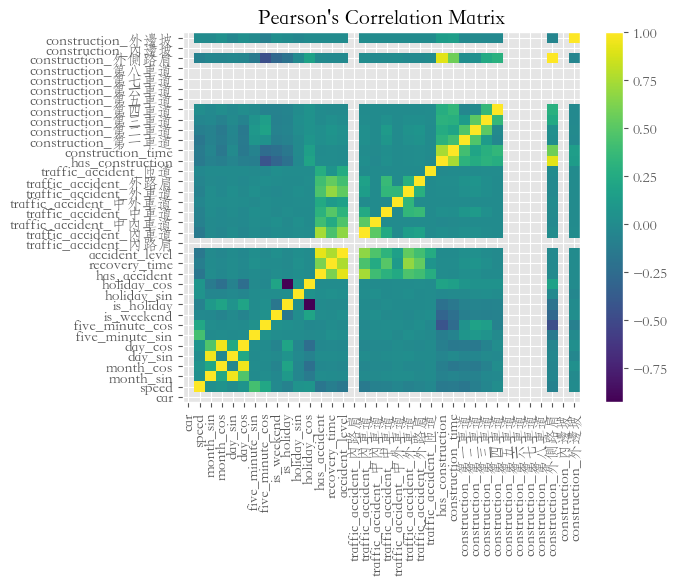

In [5]:
DQR_var = DQR(first_data[column_needed])

# import data to model class

In [6]:
m = Model()
m.import_freeway(first_data, 'speed', column_needed)

freeway imported


Please refer to https://modin.readthedocs.io/en/stable/supported_apis/defaulting_to_pandas.html for explanation.


Outliers exported to outliers.csv


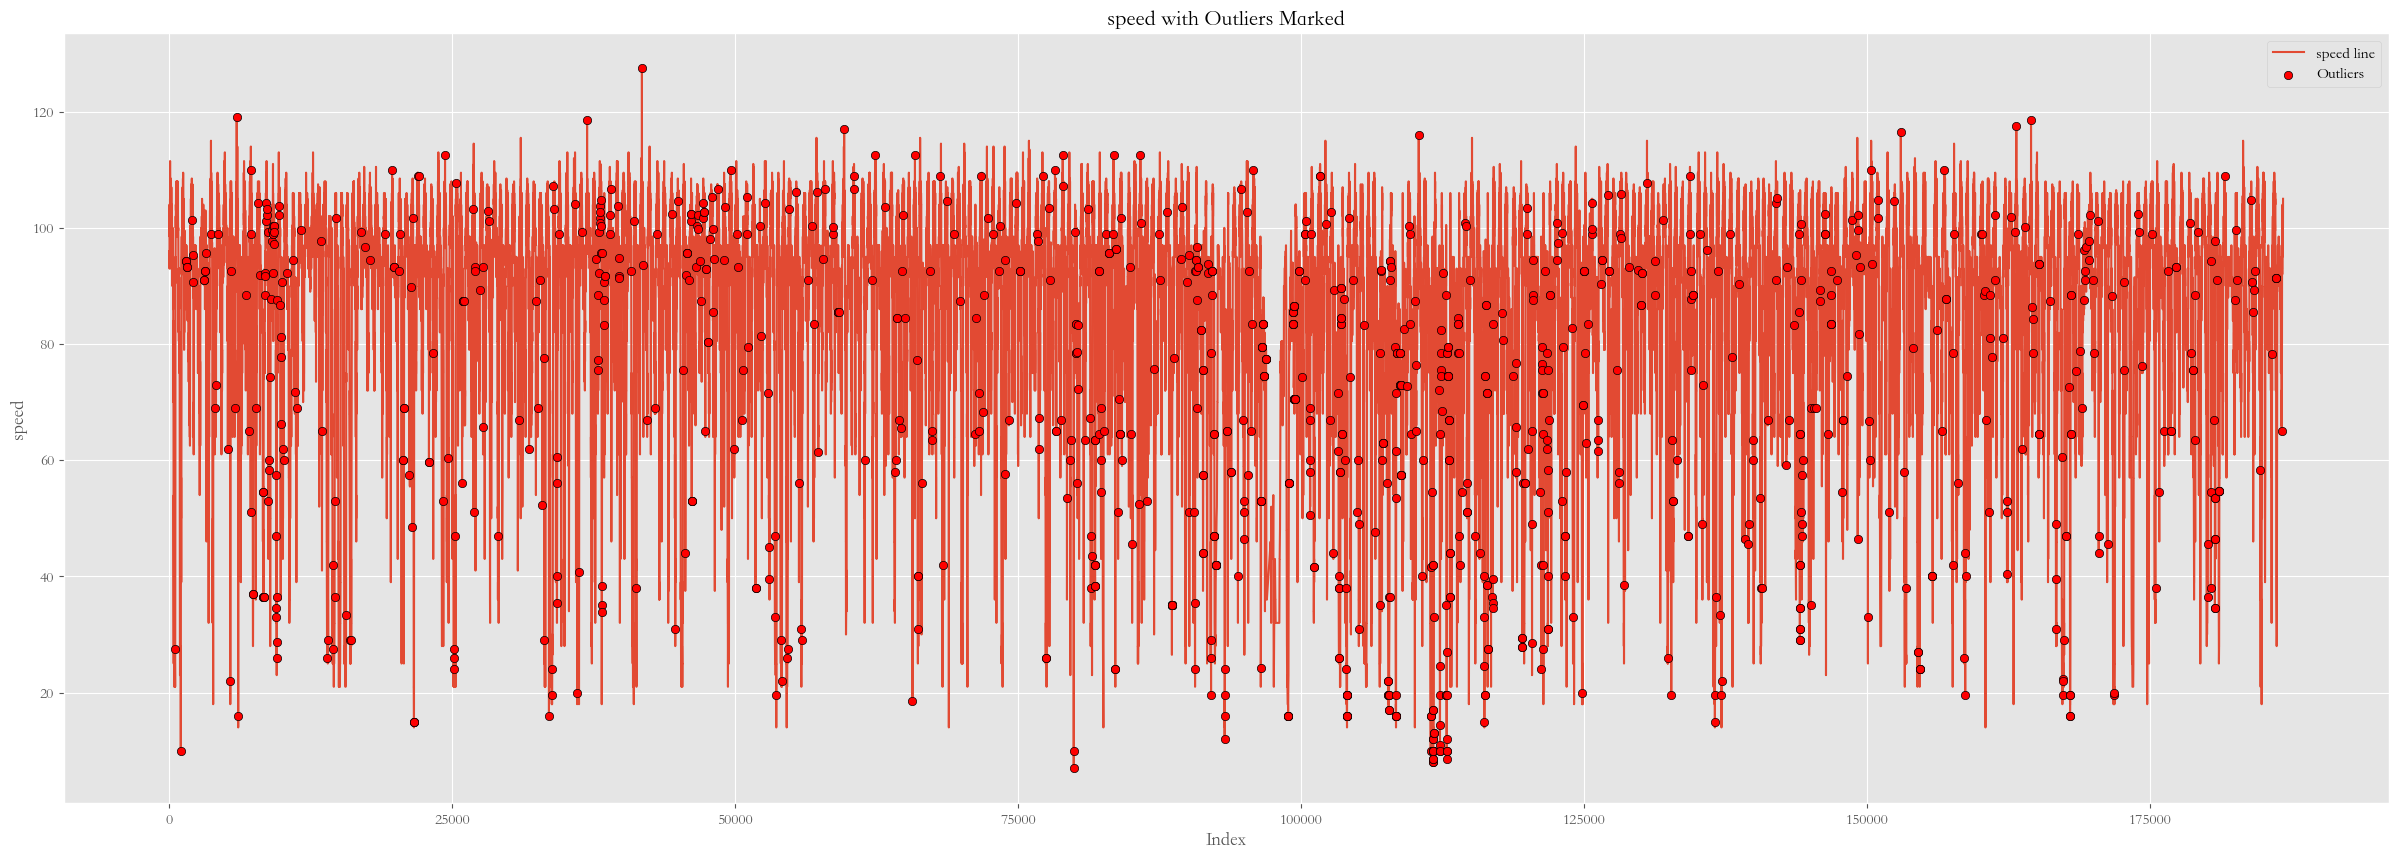

freeway imported


In [7]:
t = two_model()
t.import_freeway(first_data, 'speed', column_needed)

# show training data EDA

In [8]:
sweet_report = sv.analyze(pd.read_csv("outliers.csv"))
sweet_report.show_html('sweet_report.html')

[Step 3/3] Generating associations graph     |          | [  0%]   00:00 -> (? left)      UserWarning: Glyph 20839 (\N{CJK UNIFIED IDEOGRAPH-5167}) missing from font(s) Roboto.
Done! Use 'show' commands to display/save.   |██████████| [100%]   00:01 -> (00:00 left)


Report sweet_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


# Training and test model

### Multi-model (random forest classifier + random forest regression)

model saved, at  /Users/yuumsl1l/Documents/GitHub/Freeway-prediction-model/Model/models/01F0928N_01F0880N_8/01F0928N_01F0880N_8.joblib
/Users/yuumsl1l/Documents/GitHub/Freeway-prediction-model/Model/models/01F0928N_01F0880N_8/01F0928N_01F0880N_8.joblib
------------------Results------------------
For train dataset:
  Mean Squared Error: 153.00735622832508
  Mean Absolute Error:8.140054905410226
  R^2 Score:          0.5973486549803162
For test dataset:
  Mean Squared Error: 179.00096822453673
  Mean Absolute Error:8.21575389712806
  R^2 Score:          0.4568966200143102
--------------------end--------------------



prediction results exported


mape:  10.249227765510064 %


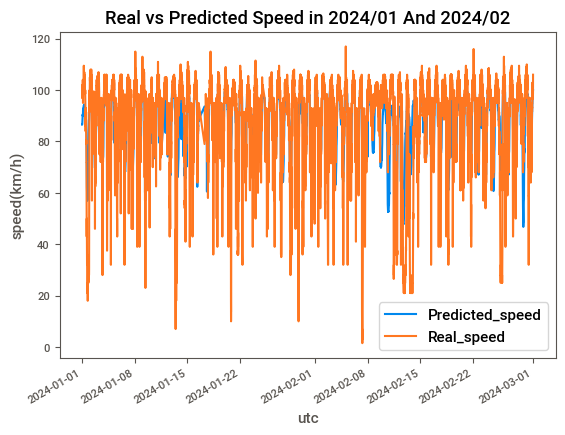

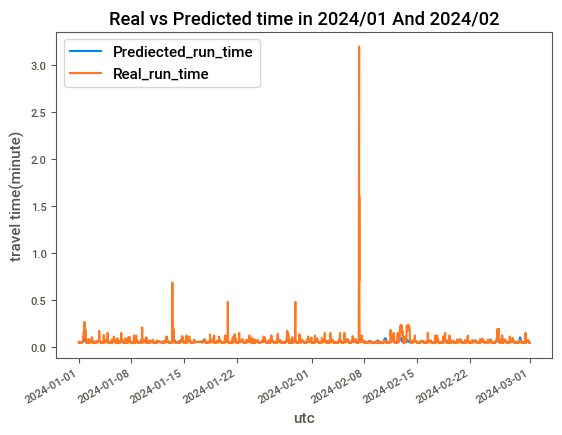

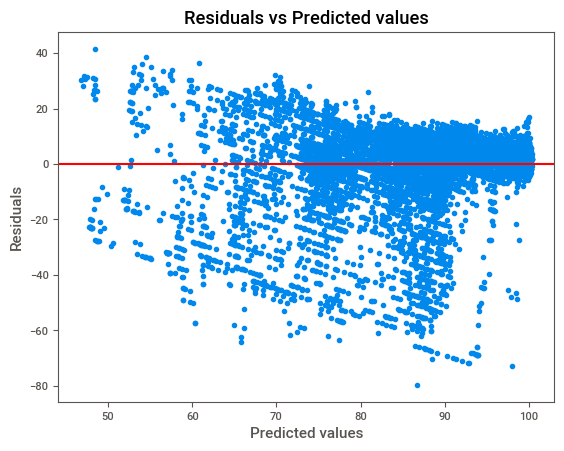

In [9]:
t.train(save_model=True, file_name="01F0928N_01F0880N.joblib")
t.test()
t.predict_all_and_export()

### random forest regression prediction model

In [10]:
# params = {
#     'n_estimators': [100, 200, 300, 400],
#     'max_depth': list(range(3, 10)),
#     'learning_rate': [0.1, 0.05, 0.02, 0.01],
#     'min_child_weight': [1, 0.5, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005, 0.002, 0.001]
# }
# m.train_XGBoost_random_search(
#     params=params,
#     save_model=True, 
#     file_name="01F0928N_01F0880N_XGBoost_random_search.joblib"
# )
# m.test()

# m.train(
#     _n_estimators=100, 
#     _max_features=None, 
#     _max_depth=None, 
#     _min_samples_leaf=1, 
#     save_model=True, 
#     file_name="01F0928N_01F0880N.joblib"
# )
# m.train_halving_random(
#     save_model=True, 
#     file_name="01F0928N_01F0880N_halving_random.joblib"
# )
# m.train_grid_search(
#     save_model=True, 
#     file_name="01F0928N_01F0880N_grid_search.joblib"
# )
# m.train_halving_random(
#     save_model=True, 
#     file_name="01F0928N_01F0880N_halving_random.joblib"
# )
# m.test()

# m.import_model("01F0928N_01F0880N_halving_random_8.joblib")
# car_code = car_map[31]
# query = f"car == {car_code}"
# m.predict(query=query, n=10, type="query_random")

# column_needed = [
#     'speed',
#     'car', 
#     'month_sin', 'month_cos', 'day_sin', 'day_cos',
#     'five_minute_sin', 'five_minute_cos',
#     'is_weekend', 
#     'weekday_sin', 'weekday_cos', 
#     'is_holiday', 
#     'holiday_sin', 'holiday_cos',
#     'has_accident', 
#     'recovery_time', 
#     'traffic_accident_內路肩', 'traffic_accident_內車道', 'traffic_accident_中內車道', 'traffic_accident_中車道', 'traffic_accident_中外車道', 'traffic_accident_外車道', 'traffic_accident_外路肩', 'traffic_accident_匝道', 
#     'has_construction', 
#     'construction_time', 
#     'construction_第一車道', 'construction_第二車道', 'construction_第三車道', 'construction_第四車道', 'construction_第五車道', 'construction_第六車道', 'construction_第七車道', 'construction_第八車道', 'construction_外側路肩', 'construction_內邊坡', 'construction_外邊坡'
#     ]
# first_data = preprocessed_data.query(f"ETagPairID == '01F0928N-01F0880N'")
# m.import_freeway(first_data, 'speed', column_needed)
# m.import_model("01F0928N_01F0880N_halving_random.joblib")
# m.predict_all_and_export()